In [1]:
import numpy as np
import pandas as pd
data=pd.read_csv('/content/6 class csv.csv')
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
data[['Star color',	'Spectral Class']]=data[['Star color',	'Spectral Class']].apply(LabelEncoder().fit_transform)

In [ ]:
data[['Temperature (K)','Absolute magnitude(Mv)']]=StandardScaler().fit_transform(data[['Temperature (K)','Absolute magnitude(Mv)']])

In [ ]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,-0.779382,0.002400,0.1700,1.116745,0,10,5
1,-0.782110,0.000500,0.1542,1.162414,0,10,5
2,-0.828477,0.000300,0.1020,1.362213,0,10,5
3,-0.807496,0.000200,0.1600,1.167171,0,10,5
4,-0.897819,0.000138,0.1030,1.491607,0,10,5


In [3]:
data['Star type'].unique()

array([0, 1, 2, 3, 4, 5])

In [4]:
X=data.drop(columns=['Star type']).values
Y=data['Star type'].values.reshape((data.shape[0],1))
X.shape,Y.shape

((240, 6), (240, 1))

In [6]:
from keras.utils import to_categorical
Y=to_categorical(Y,6)
Y.shape

(240, 6)

In [7]:
!pip install neat-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 KB 2.5 MB/s eta 0:00:00


In [8]:
!pip install visualize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visualize: filename=visualize-0.5.1-py3-none-any.whl size=11480 sha256=f82aa1f5aff6ec7f35438b31970cea94c96720d22c5be979bae6b6b7a7e3254a
  Stored in directory: /root/.cache/pip/wheels/9d/06/26/944128c987db913298520c2b476bb652faf6a5d00accb3f59c
Successfully built visualize


In [9]:
import neat

In [10]:
from __future__ import print_function

import copy
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np


def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    #plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    t_values = [t for t, I, v, u in spikes]
    v_values = [v for t, I, v, u in spikes]
    u_values = [u for t, I, v, u in spikes]
    I_values = [I for t, I, v, u in spikes]

    fig = plt.figure()
    plt.subplot(3, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(3, 1, 2)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(3, 1, 3)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled',
                       'shape': 'box'}
        input_attrs['fillcolor'] = node_colors.get(k, 'lightgray')
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled'}
        node_attrs['fillcolor'] = node_colors.get(k, 'lightblue')

        dot.node(name, _attributes=node_attrs)

    if prune_unused:
        connections = set()
        for cg in genome.connections.values():
            if cg.enabled or show_disabled:
                connections.add(cg.key)

        used_nodes = copy.copy(outputs)
        pending = copy.copy(outputs)
        while pending:
            new_pending = set()
            for a, b in connections:
                if b in pending and a not in used_nodes:
                    new_pending.add(a)
                    used_nodes.add(a)
            pending = new_pending
    else:
        used_nodes = set(genome.nodes.keys())

    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled'}
        attrs['fillcolor'] = node_colors.get(n, 'white')
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            #if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot


In [11]:
import visualize

In [ ]:
xor_inputs = np.array([(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)])
xor_outputs = np.array([(0.0,), (1.0,), (1.0,), (0.0,)])

In [15]:
data.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color', 'Spectral Class'],
      dtype='object')

In [17]:

import os
import numpy as np

import neat
import visualize

# 2-input XOR inputs and expected outputs.
xor_inputs = X
xor_outputs = Y


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2


def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    # config.input_nodes = 6
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    # p=neat.population.Population(config)
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))
    # Run for up to 300 generations.
    winner = p.run(eval_genomes,25)
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(xor_inputs, xor_outputs):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    node_names = {-1: 'Temperature (K)', -2: 'Luminosity(L/Lo)', -3:'Radius(R/Ro)', -4: 'Absolute magnitude(Mv)',-5:'Star color',
                  -6: 'Spectral Class', 
                  0: 'Star-Type 1',1: 'Star-Type 2',2: 'Star-Type 3',3: 'Star-Type 4',4: 'Star-Type 5',5: 'Star-Type 6'}
    draw_net(config, winner, True, node_names=node_names)
    draw_net(config, winner, True, node_names=node_names, prune_unused=True)
    plot_stats(stats, ylog=False, view=True)
    plot_species(stats, view=True)

    p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    p.run(eval_genomes, 10)


Streaming output truncated to the last 5000 lines.
    33    5     2    -36.0    0.967     5
    34    5     2    -36.0    0.967     5
    35    5     2   -122.0    0.447     5
    36    5     2   -196.0    0.000     5
    37    5     2    -36.0    0.967     5
    38    5     2    -36.0    0.967     5
    39    5     2   -196.0    0.000     5
    40    5     2    -36.0    0.967     5
    41    5     2    -36.0    0.967     5
    42    5     2    -39.9    0.932     4
    43    5     2    -36.0    0.483     5
    44    5     2   -134.0    0.187     4
    45    5     2    -36.0    0.568     5
    46    5     2    -36.0    0.967     5
    47    5     2    -36.0    0.967     5
    48    5     2   -146.0    0.302     5
    49    5     2    -30.5    0.991     4
    50    5     2    -93.0    0.311     5
    51    5     2   -122.0    0.224     4
    52    5     2   -143.0    0.320     5
    53    5     2    -36.2    0.948     5
    54    5     2    -36.0    0.767     4
    55    5     2    -70.

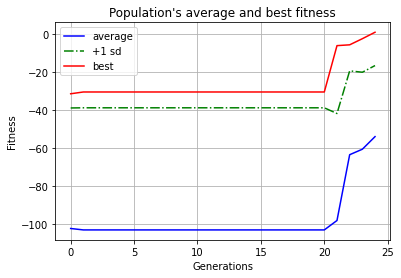

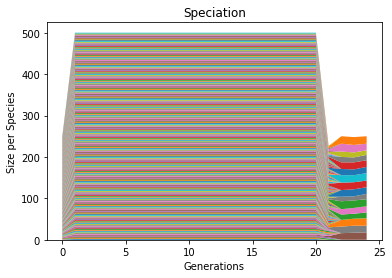

Mean genetic distance 3.317, standard deviation 0.211
Mean genetic distance 3.317, standard deviation 0.211
Mean genetic distance 3.317, standard deviation 0.211
Mean genetic distance 3.317, standard deviation 0.211
Mean genetic distance 3.317, standard deviation 0.211
Mean genetic distance 3.317, standard deviation 0.211
Mean genetic distance 3.317, standard deviation 0.211
Mean genetic distance 3.317, standard deviation 0.211
Mean genetic distance 3.317, standard deviation 0.211
Mean genetic distance 3.317, standard deviation 0.211


In [18]:
if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    local_dir = os.path.dirname('/content/config-feedforward')
    config_path = os.path.join(local_dir, 'config-feedforward')
    run(config_path)